In [1]:
# =========================================
# Etape 1 : Configuration de l'environnement
# =========================================

import os
from itertools import count
from dotenv import load_dotenv
import pytesseract

load_dotenv()

# Définir les chemins dynamiquement
user_profile = os.path.expanduser("~")  # Équivaut à $env:USERPROFILE
# emplacement de l'exécutable
tesseract_path = os.path.join(user_profile, "anaconda3", "envs", "Medipy", "Library", "bin", "tesseract.exe")
# pointe vers le dossier contenant les fichiers de données de langue Tesseract
tessdata_prefix = os.path.join(user_profile, "anaconda3", "envs", "Medipy", "share", "tessdata")

# Configurer pytesseract
pytesseract.pytesseract.tesseract_cmd = tesseract_path
os.environ["TESSDATA_PREFIX"] = tessdata_prefix # env variable

# vérif
print("Tesseract cmd path:", pytesseract.pytesseract.tesseract_cmd)
print("TESSDATA_PREFIX:", os.environ["TESSDATA_PREFIX"])

In [2]:
# =========================================
# Etape 2 : Extraction de texte à partir d'un PDF
# =========================================

import requests
import pdf2image
import pytesseract

# Téléchargement du fichier PDF
pdf_url = 'https://www.mdpi.com/1422-0067/21/4/1306/pdf?version=1581850486'
response = requests.get(pdf_url)

if response.status_code == 200:
    # Conversion PDF ➡️ Images
    pages = pdf2image.convert_from_bytes(response.content)

    # Extraction de texte avec OCR (limite à 6 premières pages)
    extracted_text = []
    for page_number, page_data in enumerate(pages):
        if page_number < 6:  # Traite uniquement les 6 premières pages
            text = pytesseract.image_to_string(page_data)
            extracted_text.append(text)

    # Fusionner le texte extrait
    full_text = " ".join(extracted_text)

    # Afficher les 500 premiers caractères pour vérification
    print(full_text[:500])
else:
    print(f"Erreur lors du téléchargement du PDF : {response.status_code}")

International Journal of

ZA
Molecular Sciences (moPt)

Review

Hopes and Limits of Adipose-Derived Stem Cells
(ADSCs) and Mesenchymal Stem Cells (MSCs) in
Wound Healing

Loubna Mazini '*, Luc Rochette 2, Brahim Admou 3®, Said Amal 4 and Gabriel Malka !

1 Laboratoire Cellules Souches et Régénération Cellulaire et Tissulaire, Centre interface Applications

Médicales (CIAM), Université Mohammed VI Polytechnique, Ben-Guerir 43 150, Morocco;
gabriel.malka@um6p.ma

Equipe d’Accueil (EA 7460), Physio


In [3]:
# =========================================
# Etape 3 : Extraction d'entités biomédicales
# =========================================

import requests
from bs4 import BeautifulSoup

# URL de la page PubMed
url = "https://pubmed.ncbi.nlm.nih.gov/32075181/"
response = requests.get(url)

# Extraction HTML avec BeautifulSoup
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    title = soup.find('h1', class_='heading-title').get_text(strip=True)
    authors = [author.get_text(strip=True) for author in soup.find_all('a', class_='full-name')]
    print("Titre :", title)
    print("Auteurs :", ", ".join(authors))
else:
    print(f"Erreur lors de l'accès à PubMed : {response.status_code}")


Titre : Hopes and Limits of Adipose-Derived Stem Cells (ADSCs) and Mesenchymal Stem Cells (MSCs) in Wound Healing
Auteurs : Loubna Mazini, Luc Rochette, Brahim Admou, Said Amal, Gabriel Malka, Loubna Mazini, Luc Rochette, Brahim Admou, Said Amal, Gabriel Malka


In [4]:
# =========================================
# Etape 4 : Extraction d'entités biomédicales
# =========================================

import nltk
import os
import re

# Configurer le chemin pour NLTK
nltk_data_path = os.getenv("PDF2_PATH_NLTK_DATA")
# cela enregistre le fichier sous :
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)

# Télécharger le tokenizer Punkt si nécessaire
nltk.download('punkt', download_dir=nltk_data_path)

def clean_text(text):
    """
    Supprime les sections inutiles et nettoie le texte.
    """
    # Filtrer les lignes courtes et celles qui commencent par des mots-clés inutiles
    clean = "\n".join([
        row for row in text.split("\n")
        if len(row.split(" ")) > 3 and not row.lower().startswith(("figure", "(a)"))
    ])
    return clean

def remove_headers_footers(text, patterns):
    """
    Supprime les en-têtes et pieds de page récurrents basés sur des motifs.
    """
    for pattern in patterns:
        text = re.sub(pattern, '', text)
    return text

# todo : rendre insensible à la casse le mot "1. Introduction"
def extract_relevant_text(full_text, start_keyword="1. Introduction"):
    """
    Extrait la section de texte après le mot-clé 'Introduction'.
    """
    if start_keyword.lower() in full_text.lower():
        # Découpe à partir du mot-clé "Introduction"
        relevant_text = full_text.split(start_keyword, 1)[1]
        return relevant_text
    return full_text  # Retourne tout si le mot-clé n'est pas trouvé

# motifs d'en-têtes et pieds de page récurrents (spécifiques à l'article)
header_footer_patterns = [
    r"Int\. J\. Mol\. Sci\.\s?\d{4},\s?\d{2},\s?\d+;",  # Ex. "Int. J. Mol. Sci. 2020, 21, 1306;"
    r"www\.mdpi\.com/journal/ijms",                   # Ex. "www.mdpi.com/journal/ijms"
    r"\s?Int\. J\. Mol\. Sci\. \d{4}, \d{2}, \d+ \d+ of \d+",  # Ex. "Int. J. Mol. Sci. 2020, 21, 1306 2 of 19"
]

# Appliquer les transformations sur le texte extrait
if 'full_text' in locals():
    # Extraction de la section après "Introduction"
    relevant_text = extract_relevant_text(full_text, start_keyword="Introduction")

    # Suppression des en-têtes et pieds de page
    text_without_headers = remove_headers_footers(relevant_text, header_footer_patterns)

    # Nettoyage des lignes inutiles
    cleaned_text = clean_text(text_without_headers)

    # Tokenisation en phrases
    sentences = nltk.tokenize.sent_tokenize(cleaned_text)

    # Vérifications
    print(f"Nombre de phrases extraites : {len(sentences)}")
    print("Exemple de phrases :", sentences[:3])
    print("Texte nettoyé : ", cleaned_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jonat\Code\DataScience\MedipyJupyter\data\PDF
[nltk_data]     2...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Nombre de phrases extraites : 114
Exemple de phrases : ['Multipotent mesenchymal/stromal stem cells (MSCs) have been identified as residual stem cells in\nalmost all adult organs, especially within adipose tissue (AT).', 'These cells present, in vitro, the typical\nmesenchymal cell characteristics and are isolated within the stromal vascular fraction (SVF) [1,2].', 'Mainly called adipose derived stem cells (ASCs or ADSCs) and isolated in a less invasive and more\nreproducible manner, these cells are more proliferative and have immunosuppressive properties that\nare able to inactivate T cells [3,4].']
Texte nettoyé :  Multipotent mesenchymal/stromal stem cells (MSCs) have been identified as residual stem cells in
almost all adult organs, especially within adipose tissue (AT). These cells present, in vitro, the typical
mesenchymal cell characteristics and are isolated within the stromal vascular fraction (SVF) [1,2].
Mainly called adipose derived stem cells (ASCs or ADSCs) and isolated i

In [5]:
# =========================================
# Etape 5 : Extraction d'entités biomédicales
# =========================================

import requests
import hashlib

def query_plain(text, url="http://bern2.korea.ac.kr/plain"):
    """API de liaison d'entités biomédicales"""
    return requests.post(url, json={'text': str(text)}).json()

entity_list = []

# Extraire les entités pour chaque phrase,
# on ignore la dernière phrase si elle est incomplète
for s in sentences[:-1]:
    entity_list.append(query_plain(s))

# Liste finale des entités annotées
parsed_entities = []

# Vérification et parsing des entités
for entities in entity_list:
    e = []

    # Vérification des annotations
    # si aucune entité n'est trouvée, on ajoute le texte brut
    if not entities.get('annotations'):
        parsed_entities.append({
            'text': entities['text'],
            'text_sha256': hashlib.sha256(entities['text'].encode('utf-8')).hexdigest()
        })
        continue

    # Extraction des détails d'entités
    for entity in entities['annotations']:
        other_ids = [id for id in entity['id'] if not id.startswith("BERN")]
        entity_type = entity['obj']
        entity_name = entities['text'][entity['span']['begin']:entity['span']['end']]

        # Gestion des ID d'entité
        try:
            entity_id = [id for id in entity['id'] if id.startswith("BERN")][0]
        except IndexError:
            entity_id = entity_name
        e.append({
            'entity_id': entity_id,
            'other_ids': other_ids,
            'entity_type': entity_type,
            'entity': entity_name
        })

    # Ajout des entités extraites
    parsed_entities.append({
        'entities': e,
        'text': entities['text'],
        'text_sha256': hashlib.sha256(entities['text'].encode('utf-8')).hexdigest()
    })

# Vérification finale
print(f"Nombre de phrases avec entités : {len(parsed_entities)}")
print("Exemple d'entités :", parsed_entities[:2])

Nombre de phrases avec entités : 113
Exemple d'entités : [{'entities': [{'entity_id': 'mesenchymal/stromal stem cells', 'other_ids': ['CUI-less'], 'entity_type': 'cell_type', 'entity': 'mesenchymal/stromal stem cells'}, {'entity_id': 'MSCs', 'other_ids': ['CUI-less'], 'entity_type': 'cell_line', 'entity': 'MSCs'}], 'text': 'Multipotent mesenchymal/stromal stem cells (MSCs) have been identified as residual stem cells in almost all adult organs, especially within adipose tissue (AT).', 'text_sha256': '2a2e4b44c5192a69d25a81da08e5db7a787f698b664be466159831b67fd3198a'}, {'entities': [{'entity_id': 'mesenchymal cell', 'other_ids': ['CL:0008019'], 'entity_type': 'cell_type', 'entity': 'mesenchymal cell'}, {'entity_id': 'stromal vascular fraction', 'other_ids': ['CUI-less'], 'entity_type': 'cell_type', 'entity': 'stromal vascular fraction'}], 'text': 'These cells present, in vitro, the typical mesenchymal cell characteristics and are isolated within the stromal vascular fraction (SVF) [1,2].'

In [6]:
# =========================================
# Etape 6 : Connexion à la db Neo4J
# =========================================

from neo4j import GraphDatabase
import pandas as pd

host = os.getenv("HOST_PROD")
user = os.getenv("USER_PROD")
password = os.getenv("PASSWORD_PROD")

driver = GraphDatabase.driver(host,auth=(user, password))

def test_connection():
    try:
        with driver.session() as session:
            result = session.run("RETURN 'Connexion réussie' AS message")
            for record in result:
                print(record["message"])  # Affichera "Connexion réussie"
        print("Connexion à Neo4j établie avec succès.")
    except Exception as e:
        print("Erreur de connexion :", e)

test_connection()

def neo4j_query(query, params=None):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

Connexion réussie
Connexion à Neo4j établie avec succès.


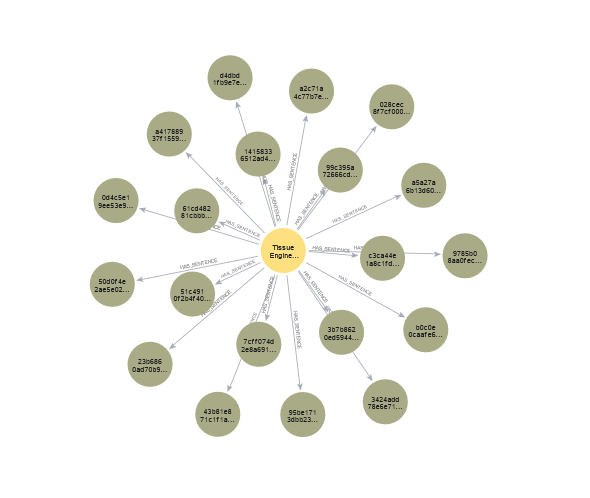

In [7]:
# =========================================
# Etape 7 : Insertion des données
# =========================================

for author in authors:
    neo4j_query("""
    MERGE (a:Author {name: $author})
    MERGE (b:Article {title: $title})
    MERGE (a)-[:WROTE]->(b)
    """, {'title': title, 'author': author})

# Vérification
print(f"Auteurs insérés : {', '.join(authors)}")
print(f"Titre inséré : {title}")

Auteurs insérés : Loubna Mazini, Luc Rochette, Brahim Admou, Said Amal, Gabriel Malka, Loubna Mazini, Luc Rochette, Brahim Admou, Said Amal, Gabriel Malka
Titre inséré : Hopes and Limits of Adipose-Derived Stem Cells (ADSCs) and Mesenchymal Stem Cells (MSCs) in Wound Healing


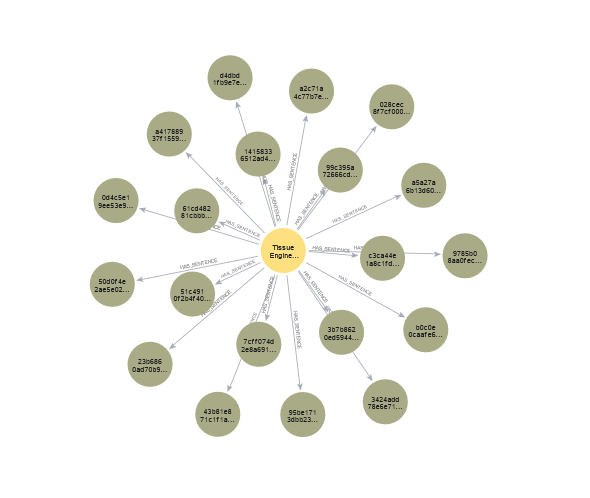

In [8]:
# =========================================
# Etape 8 : Insertion des phrases et des entités extraites
# =========================================

neo4j_query("""
MATCH (a:Article {title: $title})
UNWIND $data as row
MERGE (s:Sentence {id: row.text_sha256})
SET s.text = row.text
MERGE (a)-[:HAS_SENTENCE]->(s)
WITH s, row.entities as entities
UNWIND entities as entity
MERGE (e:Entity {id: entity.entity_id})
ON CREATE SET e.other_ids = entity.other_ids,
              e.name = entity.entity,
              e.type = entity.entity_type
MERGE (s)-[m:MENTIONS]->(e)
ON CREATE SET m.count = 1
ON MATCH SET m.count = m.count + 1
""", {'data': parsed_entities, 'title': title})

# Vérification
print(f"Nombre de phrases insérées : {len(parsed_entities)}")

Nombre de phrases insérées : 113


In [9]:
# =========================================
# Etape 9 : Extraction de relations
# =========================================

import itertools
from transformers import AutoTokenizer
from zero_shot_re import RelTaggerModel, RelationExtractor

# Chargement du modèle et du tokenizer
model = RelTaggerModel.from_pretrained("fractalego/fewrel-zero-shot")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Définition des relations possibles
relations = ['associated', 'interacts', 'causes', 'treats', 'inhibits']

# Initialisation de l'extracteur de relations
extractor = RelationExtractor(model, tokenizer, relations)

# Filtrer les phrases contenant plusieurs entités
candidates = [s for s in parsed_entities if (s.get('entities')) and (len(s['entities']) > 1)]

predicted_rels = []

# Générer toutes les combinaisons possibles de paires d'entités
for c in candidates:
    combinations = itertools.combinations(
        [{'name': x['entity'], 'id': x['entity_id']} for x in c['entities']], 2
    )
    for combination in list(combinations):
        print(f"Processing combinations: {combination}")
        try:
            # Extraction de la relation probable
            ranked_rels = extractor.rank(
                text=c['text'].replace(",", ""),
                head=combination[0]['name'],
                tail=combination[1]['name']
            )

            # Vérifier le seuil de confiance
            if ranked_rels[0][1] > 0.85:
                predicted_rels.append({
                    'head': combination[0]['id'],
                    'tail': combination[1]['id'],
                    'type': ranked_rels[0][0],
                    'source': c['text_sha256']
                })
                print(f"Relation trouvée: {predicted_rels[-1]}")
        except Exception as e:
            print(f"Erreur: {e}")

# Vérification des relations extraites
print(f"Nombre de relations extraites : {len(predicted_rels)}")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing combinations: ({'name': 'mesenchymal/stromal stem cells', 'id': 'mesenchymal/stromal stem cells'}, {'name': 'MSCs', 'id': 'MSCs'})
Erreur: The entity "MSCs" is not in the text.
Processing combinations: ({'name': 'mesenchymal cell', 'id': 'mesenchymal cell'}, {'name': 'stromal vascular fraction', 'id': 'stromal vascular fraction'})
Processing combinations: ({'name': 'adipose derived stem cells', 'id': 'adipose derived stem cells'}, {'name': 'ASCs', 'id': 'ASCs'})
Erreur: The entity "ASCs" is not in the text.
Processing combinations: ({'name': 'adipose derived stem cells', 'id': 'adipose derived stem cells'}, {'name': 'ADSCs', 'id': 'ADSCs'})
Erreur: The entity "ADSCs" is not in the text.
Processing combinations: ({'name': 'adipose derived stem cells', 'id': 'adipose derived stem cells'}, {'name': 'T cells', 'id': 'T cells'})
Relation trouvée: {'head': 'adipose derived stem cells', 'tail': 'T cells', 'type': 'inhibits', 'source': '9aac7107e3ef76cb940e9435cac1dc2577a4d5575e72f8

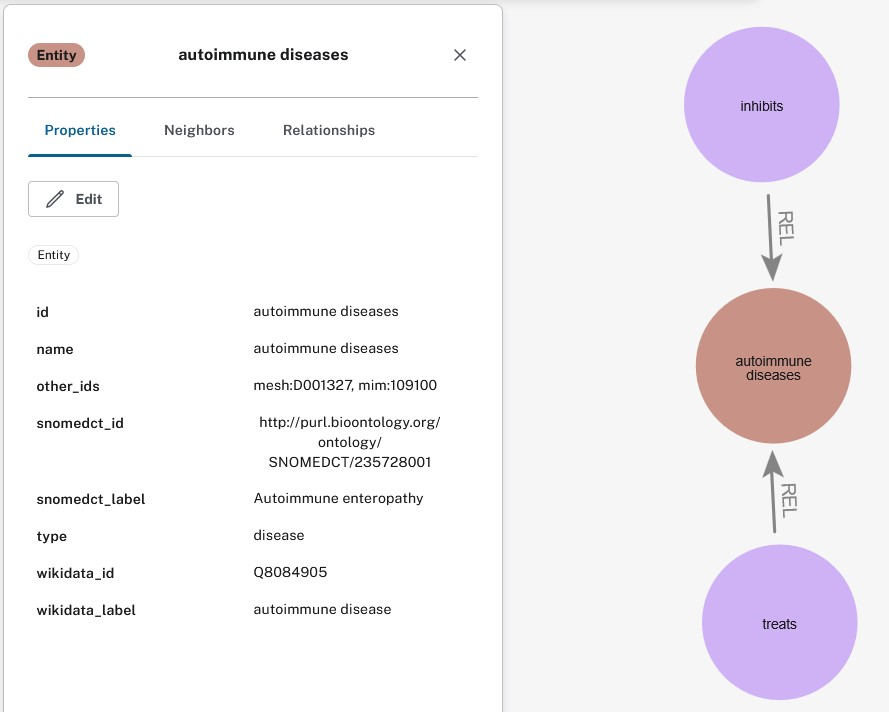

In [15]:
# =========================================
# Etape 10 : Insertion des relations
# =========================================

neo4j_query("""
UNWIND $data as row
MATCH (source:Entity {id: row.head})
MATCH (target:Entity {id: row.tail})
MATCH (text:Sentence {id: row.source})
MERGE (source)-[:REL]->(r:Relation {type: row.type})-[:REL]->(target)
MERGE (text)-[:MENTIONS]->(r)
""", {'data': predicted_rels})

print("Relations importées avec succès.")

Relations importées avec succès.


In [14]:
# =========================================
# Etape 11 : Enrichissement des entités
# =========================================

from SPARQLWrapper import SPARQLWrapper, JSON

def query_wikidata(entity_name):
    """
    Rechercher l'entité sur Wikidata et obtenir son QID.
    """
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    query = """
    SELECT ?item ?itemLabel WHERE {
      ?item ?label "%s"@en.
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    LIMIT 1
    """ % entity_name.replace('"', '\\"')
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    if results["results"]["bindings"]:
        item = results["results"]["bindings"][0]["item"]["value"]
        itemLabel = results["results"]["bindings"][0]["itemLabel"]["value"]
        return {'wikidata_id': item.split('/')[-1], 'label': itemLabel}
    else:
        return None

# Exemple d'utilisation
entity_name = "autoimmune diseases"
result = query_wikidata(entity_name)
print(result)

{'wikidata_id': 'Q8084905', 'label': 'autoimmune disease'}


In [11]:
# =========================================
# Etape 12 : Enrichissement des entités
# =========================================

entities = neo4j_query("""
MATCH (e:Entity)
RETURN e.id AS id, e.name AS name
""")

# Enrichir chaque entité avec Wikidata
for index, row in entities.iterrows():
    wikidata_info = query_wikidata(row['name'])
    if wikidata_info:
        neo4j_query("""
        MATCH (e:Entity {id: $id})
        SET e.wikidata_id = $wikidata_id,
            e.wikidata_label = $label
        """, {'id': row['id'], 'wikidata_id': wikidata_info['wikidata_id'], 'label': wikidata_info['label']})
        print(f"Entité {row['name']} enrichie avec Wikidata ID {wikidata_info['wikidata_id']}")
    else:
        print(f"Aucune correspondance Wikidata trouvée pour l'entité {row['name']}")

Entité people enrichie avec Wikidata ID Q109205190-266291D8-366A-4755-AA3E-136C7A71C936
Entité skin diseases enrichie avec Wikidata ID Q949302
Aucune correspondance Wikidata trouvée pour l'entité chronic wounds
Aucune correspondance Wikidata trouvée pour l'entité non-healing and diabetic ulcers
Entité pluripotent enrichie avec Wikidata ID L618823
Entité pluripotent stem cells enrichie avec Wikidata ID Q15952110
Aucune correspondance Wikidata trouvée pour l'entité bone marrow stem cells
Aucune correspondance Wikidata trouvée pour l'entité fat-derived stem cells
Entité stem cells enrichie avec Wikidata ID Q48196
Aucune correspondance Wikidata trouvée pour l'entité hematopoietic stem cells
Entité leukemia enrichie avec Wikidata ID L37066
Entité autoimmune diseases enrichie avec Wikidata ID Q8084905
Entité stem cell enrichie avec Wikidata ID Q48196
Entité joint diseases enrichie avec Wikidata ID Q708176
Entité human enrichie avec Wikidata ID Q87348881
Entité Mesenchymal stem cells enrichie

In [12]:
# =========================================
# Etape 13 : Enrichissement des entités
# =========================================

import requests

def query_snomedct(entity_name, api_key):
    """
    Rechercher l'entité sur SNOMED-CT via BioPortal et obtenir son identifiant.
    """
    url = f"http://data.bioontology.org/search?q={entity_name}&ontologies=SNOMEDCT&apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        results = response.json()
        if results['collection']:
            snomedct_id = results['collection'][0]['@id']
            pref_label = results['collection'][0].get('prefLabel', '')
            return {'snomedct_id': snomedct_id, 'pref_label': pref_label}
    return None

# clé API BioPortal
api_key = os.getenv("API_KEY_BIOPORTAL")

# Exemple d'utilisation
entity_name = "autoimmune diseases"
result = query_snomedct(entity_name, api_key)
print(result)

{'snomedct_id': 'http://purl.bioontology.org/ontology/SNOMEDCT/235728001', 'pref_label': 'Autoimmune enteropathy'}


In [13]:
# =========================================
# Etape 14 : Enrichissement des entités avec SNOMED-CT
# =========================================

for index, row in entities.iterrows():
    snomedct_info = query_snomedct(row['name'], api_key)
    if snomedct_info:
        neo4j_query("""
        MATCH (e:Entity {id: $id})
        SET e.snomedct_id = $snomedct_id,
            e.snomedct_label = $pref_label
        """, {'id': row['id'], 'snomedct_id': snomedct_info['snomedct_id'], 'pref_label': snomedct_info['pref_label']})
        print(f"Entité {row['name']} enrichie avec SNOMED-CT ID {snomedct_info['snomedct_id']}")
    else:
        print(f"Aucune correspondance SNOMED-CT trouvée pour l'entité {row['name']}")

Entité people enrichie avec SNOMED-CT ID http://purl.bioontology.org/ontology/SNOMEDCT/284619004
Entité skin diseases enrichie avec SNOMED-CT ID http://purl.bioontology.org/ontology/SNOMEDCT/2081000124103
Entité chronic wounds enrichie avec SNOMED-CT ID http://purl.bioontology.org/ontology/SNOMEDCT/57028002
Entité non-healing and diabetic ulcers enrichie avec SNOMED-CT ID http://purl.bioontology.org/ontology/SNOMEDCT/237637005
Aucune correspondance SNOMED-CT trouvée pour l'entité pluripotent
Entité pluripotent stem cells enrichie avec SNOMED-CT ID http://purl.bioontology.org/ontology/SNOMEDCT/418926001
Entité bone marrow stem cells enrichie avec SNOMED-CT ID http://purl.bioontology.org/ontology/SNOMEDCT/167934009
Entité fat-derived stem cells enrichie avec SNOMED-CT ID http://purl.bioontology.org/ontology/SNOMEDCT/472858001
Entité stem cells enrichie avec SNOMED-CT ID http://purl.bioontology.org/ontology/SNOMEDCT/418926001
Entité hematopoietic stem cells enrichie avec SNOMED-CT ID http